#Midterm
Steps

1) Data pre-processing:
Clean and prepare your data by removing irrelevant characters, handling missing values, and converting text to numerical features using NLP techniques.

2) Feature engineering:
Extract relevant features from the reviews like sentiment scores, keyword counts, and review length.

3) Model selection and tuning:
Try different models and tune hyperparameters to find the best performing one for your data.

4) Evaluation metrics:
Use metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), or R-squared to assess the model's performance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [ ]:
#loading the data set
train_data = pd.read_csv("/content/drive/MyDrive/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv")
train_data.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Merge test_data with train_data to get metadata for each 'Id'
test_data = test_data.merge(train_data, on="Id", how="left")
test_data.head() #will deal with processing later....

#Step 1: Data Preprocessing/Cleaning

In [ ]:
#Fixing Helpfulness, no Nans
train_data.loc[train_data['HelpfulnessDenominator'] == 0, 'HelpfulnessDenominator'] = 1
train_data['HelpfulnessNumerator'] = train_data['HelpfulnessNumerator'].fillna(0)
train_data['HelpfulnessDenominator'] = train_data['HelpfulnessDenominator'].fillna(1)

#dropping all rows where text is missing cuz thats kinda the main thing we are basing our system off of
train_data = train_data.dropna(subset=["Text"])
train_data = train_data.dropna(subset=["Summary"])

#dropping all irrelvant rows that dont add value to the prediction.... maybe add Summary back here
train_data = train_data.drop(columns=["Id","ProductId","UserId"])
train_data = train_data.dropna(subset=["Score"])
train_data.head()

#Step 2: Feature Engineering

In [ ]:
#Creating new feature FullText that is just a combo of Summary and Text & dropping now irrelvant features
train_data['FullText'] = train_data['Summary'] + " " + train_data['Text']
train_data = train_data.drop(columns=["Summary","Text"])

#Creating new feature Helpfulness Ratio & dropping now irrelevant features
train_data['HelpfulnessRatio'] = train_data['HelpfulnessNumerator'] / (train_data['HelpfulnessDenominator'] + 1e-5)
train_data = train_data.drop(columns=["HelpfulnessNumerator","HelpfulnessDenominator"])
train_data.head()

In [ ]:
#Steps for getting rid of all the stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text(text):
    #Converting to lowercase
    text = str(text).lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    return ' '.join([word for word in text.split() if word not in stop_words])

train_data = train_data.sample(n=20000, random_state=42) #using this so I can make processing faster
train_data['FullText'] = train_data['FullText'].apply(preprocess_text)
train_data.head()

In [ ]:
# Use TF-IDF on the 'Text' column to convert text to numerical features
tfidf = TfidfVectorizer(max_df=0.05, max_features=500, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(train_data["FullText"])

#Reducing the TFIDF matrix
n_components = 50  # Choose the number of components
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(tfidf_matrix)

#Getting our X and y
X = pd.concat([train_data[["HelpfulnessRatio", "Time"]].reset_index(drop=True),pd.DataFrame(reduced_matrix)], axis=1)
X.columns = X.columns.astype(str)
y = train_data["Score"]

In [ ]:
X.head()

,HelpfulnessRatio,Time,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0.857142,1264896000,0.135762,0.028893,-0.001467,-0.004764,0.066582,0.174194,0.113602,-0.006518,...,-0.052972,-0.086983,-0.062776,0.049775,-0.065200,0.074226,-0.005788,0.014172,0.006356,-0.037994
1,0.913043,975369600,0.273571,-0.046034,-0.000165,-0.011338,-0.017705,0.005458,0.029552,-0.000935,...,-0.012811,0.032188,0.128164,0.133071,-0.070985,0.054846,0.074090,0.043737,-0.004532,-0.082479
2,0.000000,1375401600,0.098722,0.035538,0.044599,-0.027280,0.115769,0.017939,0.057327,0.065411,...,-0.084646,-0.046006,0.033276,-0.008423,0.014697,-0.024575,0.054717,-0.031815,0.016945,-0.029903
3,0.000000,1004486400,0.139687,-0.025822,-0.019837,0.017366,-0.033641,-0.027977,0.070947,-0.027634,...,-0.169726,-0.025996,-0.039239,0.055323,0.031038,0.000951,0.131850,-0.021348,0.006662,0.017285
4,0.499999,1340496000,0.201665,-0.031795,-0.040939,-0.066396,-0.050908,0.110387,0.005058,0.016739,...,0.034510,-0.095612,-0.055269,-0.065487,0.044676,0.031221,0.080211,-0.057055,-0.072572,-0.075522


#Step 3.1: Model Selection

In [ ]:
#creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
#Random Forest Model
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42, max_depth=12, min_samples_leaf=4,min_samples_split=2,n_estimators=300)
rf_model.fit(X_train, y_train)

# Make predictions on the test set for random Forest
y_predrf = rf_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_predrf))
print("cross-validation score:")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(cv_scores.mean())

In [ ]:
#XGB model
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train = y_train - 1
y_test = y_test - 1
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_predXGB = xgb_model.predict(X_test)
print("XGB:")
print(classification_report(y_test, y_predXGB))
print("cross-validation score:")
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print(cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB:
              precision    recall  f1-score   support

           0       0.20      0.08      0.12        12
           1       0.00      0.00      0.00        13
           2       0.47      0.25      0.33        28
           3       0.14      0.06      0.08        35
           4       0.64      0.92      0.75       112

    accuracy                           0.56       200
   macro avg       0.29      0.26      0.26       200
weighted avg       0.46      0.56      0.49       200

cross-validation score:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:33:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

0.5375


#Step 3.2: Comparing Models & Tuning Hyper Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# Example for a Random Forest model
param_grid = {
    'n_estimators': [10, 20, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 20}
Best cross-validated score: 0.56875


#Step 4: Predicting our Testing Data & Evaluating

In [ ]:
test_data.head()

,Id,Score_x,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score_y
0,1323432,NaN,B0034G4P30,A120UTHQDQIJGH,0,0,1391040000,Okay for a rental,This movie was just alright for me. I think pe...,NaN
1,1137299,NaN,B0012IWO0I,A3SJBFCTJWBFT2,1,1,1388188800,Great for kids,My kids love this movie. Exciting and fun to ...,NaN
2,1459366,NaN,B005FUTBSC,A1V6FRU7EXP6N9,0,0,1356739200,good movie,"The effects were good, not the best but far fr...",NaN
3,931601,NaN,B000AREXBU,ARXDDR76Z5Q2I,5,5,1169510400,Excellent quality dvd. Don't pay big bucks fo...,"I just got a copy of this S. Korean dvd of ""He...",NaN
4,1311995,NaN,B002ZG99B8,A2XAS9GVZL3B1,2,2,1392595200,A mixed review,"OK, to put this clearly and bluntly... if you ...",NaN


In [ ]:
#Prepare the testing data for prediction
#Fixing Helpfulness, no Nans
test_data.loc[test_data['HelpfulnessDenominator'] == 0, 'HelpfulnessDenominator'] = 1
test_data['HelpfulnessNumerator'] = test_data['HelpfulnessNumerator'].fillna(0)
test_data['HelpfulnessDenominator'] = test_data['HelpfulnessDenominator'].fillna(1)

#dropping all rows where text is missing cuz thats kinda the main thing we are basing our system off of
test_data = test_data.dropna(subset=["Text"])
test_data = test_data.dropna(subset=["Summary"])

#dropping all irrelvant rows that dont add value to the prediction.... maybe add Summary back here
test_data = test_data.drop(columns=["ProductId","UserId","Score_y"])

#Creating new feature FullText that is just a combo of Summary and Text & dropping now irrelvant features
test_data['FullText'] = test_data['Summary'] + " " + test_data['Text']
test_data = test_data.drop(columns=["Summary","Text"])

#Creating new feature Helpfulness Ratio & dropping now irrelevant features
test_data['HelpfulnessRatio'] = test_data['HelpfulnessNumerator'] / (test_data['HelpfulnessDenominator'] + 1e-5)
test_data = test_data.drop(columns=["HelpfulnessNumerator","HelpfulnessDenominator"])
test_data.head()

##test_data = test_data.sample(n=1000, random_state=42)
test_data['FullText'] = test_data['FullText'].apply(preprocess_text)

# Use TF-IDF on the 'Text' column to convert text to numerical features
tfidf = TfidfVectorizer(max_df=0.05, max_features=500, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(test_data["FullText"])

#Reducing the TFIDF matrix
n_components = 50  # Choose the number of components
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(tfidf_matrix)

#Getting our X and y
X = pd.concat([test_data[["HelpfulnessRatio", "Time"]].reset_index(drop=True),pd.DataFrame(reduced_matrix)], axis=1)
X.columns = X.columns.astype(str)

In [ ]:
test_data.head()

,Id,Score_x,Time,FullText,HelpfulnessRatio
210429,439837,NaN,1257033600,damon lancaster good revenge movie darts throw...,0.000000
146815,1434402,NaN,1307404800,pretty good son like almost every kid america ...,0.862069
125803,566116,NaN,1058745600,review movie claire dolan firat actually meani...,0.210526
1764,1434305,NaN,1355184000,one favorites murder wrote shows excellant sin...,0.999990
168145,468259,NaN,1374537600,excellent television production one question t...,0.000000


In [ ]:
test_data["Score_x"] = rf_model.predict(X)

In [ ]:
test_data.head()

,Id,Score_x,Time,FullText,HelpfulnessRatio
210429,439837,5.0,1257033600,damon lancaster good revenge movie darts throw...,0.000000
146815,1434402,5.0,1307404800,pretty good son like almost every kid america ...,0.862069
125803,566116,5.0,1058745600,review movie claire dolan firat actually meani...,0.210526
1764,1434305,5.0,1355184000,one favorites murder wrote shows excellant sin...,0.999990
168145,468259,5.0,1374537600,excellent television production one question t...,0.000000


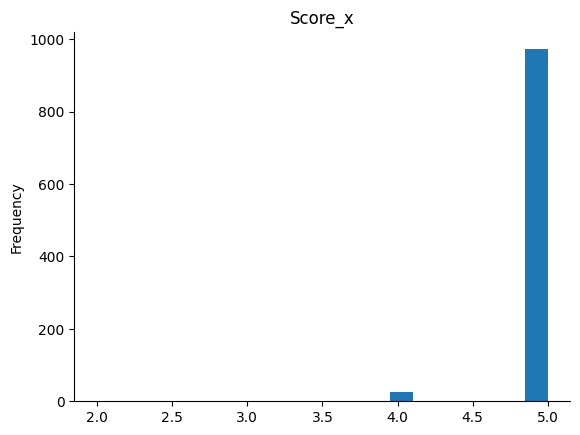

In [ ]:
from matplotlib import pyplot as plt
test_data['Score_x'].plot(kind='hist', bins=20, title='Score_x')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#Saving Predictions for Submission
submission = test_data[["Id", "Score_x"]]
submission.to_csv("predictions.csv", index=False)